# LeNet on MNIST using PyTorch

This notebook creates a LeNet architecture in PyTorch and train it on the MNIST handwritten digits dataset. I am doing this to learn PyTorch.

Steps:

- Create a Dataset
- Create a DataLoader
- Define a Network
- Run a training loop
- Plot training loss
- Classify the test dataset
- Calculate test accuracy

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/mnist/'


os.makedirs(f'{PATH}raw', exist_ok=True)

## Create a Dataset

Create a subclass of `torch.Dataset`, which defines how to read the data. In this case, `DigitDataset` will download the MNIST dataset from `http://yann.lecun.com`, extract the files and load the images and labels into memory.

In [2]:
import csv
from itertools import islice

import requests
import torch
from torch.utils.data import Dataset, DataLoader

BASE_URL = 'http://yann.lecun.com/exdb/mnist/'
TRAIN_IMAGE_FILE = 'train-images-idx3-ubyte.gz'
TRAIN_LABEL_FILE = 'train-labels-idx1-ubyte.gz'
TEST_IMAGE_FILE = 't10k-images-idx3-ubyte.gz'
TEST_LABEL_FILE = 't10k-labels-idx1-ubyte.gz'
FILES = [TRAIN_IMAGE_FILE, TRAIN_LABEL_FILE, TEST_IMAGE_FILE, TEST_LABEL_FILE]


class DigitDataset(Dataset):    
    def __init__(self, is_test=False):
        self.is_test = is_test
        self.fetch_files()
        self.extract_files()
    
    def extract_files(self):
        """
        Extract downloaded files into a format we can read more easily.
        """
        # Unzip everything
        !gunzip {PATH}raw/*.gz
        label_file = TEST_LABEL_FILE if self.is_test else TRAIN_LABEL_FILE
        image_file = TEST_IMAGE_FILE if self.is_test else TRAIN_IMAGE_FILE
        self.extract_labels(label_file[:-3])
        self.extract_images(image_file[:-3])
        assert len(self.labels) == self.images.shape[0]
        
    def extract_images(self, source_filename):
        """
        Read the image for each digit into self.images as a tensor,
        with shape (batch, channel, row, col).
        """        
        source_path = f'{PATH}raw/{source_filename}'
        with open(source_path, 'rb') as f:
            binary_data = f.read()

        num_items = int.from_bytes(binary_data[4:8], byteorder='big')
        num_rows = int.from_bytes(binary_data[8:12], byteorder='big')
        num_cols = int.from_bytes(binary_data[12:16], byteorder='big')
        images = torch.tensor([i for i in islice(binary_data, 16, None, 1)], dtype=torch.int32)
        assert images.shape[0] == num_items * num_rows * num_cols
        self.images = images.reshape(num_items, 1, num_rows, num_cols)
        
    def extract_labels(self, source_filename):
        """
        Read the label for each digit into self.labels
        """
        source_path = f'{PATH}raw/{source_filename}'
        with open(source_path, 'rb') as f:
            binary_data = f.read()

        num_items = int.from_bytes(binary_data[4:8], byteorder='big')
        self.labels = [i for i in islice(binary_data, 8, None, 1)]
        assert num_items == len(self.labels)
        assert len(set(self.labels)) == 10
        
    def fetch_files(self):
        """
        Fetch dataset files from BASE_URL if they don't exist locally.
        """
        for file in FILES:
            target_file = f'{PATH}raw/{file}'
            if not (os.path.exists(target_file) or os.path.exists(target_file[:-3])):
                print(f'Downloading {file}...', end=' ')
                response = requests.get(f'{BASE_URL}{file}', stream=True)
                response.raise_for_status()
                with open(target_file, 'wb') as f:
                    for block in response.iter_content(1024):
                        f.write(block)

                print('done')
    
    def plot(self, idx):
        fig, ax = plt.subplots()
        ax.imshow(self.images[idx][0])
        ax.set_title(self.labels[idx])
    
    def __len__(self):
        """
        How many samples there are - required by PyTorch
        """
        return len(self.images)
    
    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns tuple (image, label)
        """
        return self.images[idx], self.labels[idx]

In [3]:
train_ds = DigitDataset()
test_ds = DigitDataset(is_test=True)

gzip: /home/root/data/mnist/raw/*.gz: No such file or directory
gzip: /home/root/data/mnist/raw/*.gz: No such file or directory


## Create DataLoader

The `DataLoader` defines how the `DigitDataset` is read when training.

In [4]:
BATCH_SIZE = 128
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

## Define Network

In [5]:
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.dense_1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.dense_2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_t):
        hidden_t = self.pool(self.relu(self.conv_1(input_t)))
        hidden_t = self.pool(self.relu(self.conv_2(hidden_t)))        
        hidden_t = self.relu(self.dense_1(hidden_t.reshape(-1, 12*4*4)))
        hidden_t = self.relu(self.dense_2(hidden_t))                     
        return  self.log_softmax(self.out(hidden_t))

## Training Loop

In [8]:
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim

NUM_EPOCHS = 10

net = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

loss_history = []
for epoch in range(NUM_EPOCHS):    
    progress = tqdm(
        iterable=iter(train_dl),
        leave=False,
        desc=f'epoch {epoch + 1} / {NUM_EPOCHS}',
        total=len(train_dl),
        miniters=0
    )
    for images, labels in progress:
        optimizer.zero_grad()
        outputs = net(images.float().cuda())
        loss = criterion(outputs.cpu(), labels)
        loss.backward()
        loss_amount = loss.data.item()
        progress.set_postfix(loss=loss_amount, refresh=False)
        loss_history.append(loss_amount)
        optimizer.step()            
    
    progress.close()
    print(f'epoch {epoch + 1} / {NUM_EPOCHS}, loss: {loss_amount:0.4f}')

epoch 1 / 10, loss: 0.0253


epoch 2 / 10, loss: 0.0475


epoch 3 / 10, loss: 0.1285


epoch 4 / 10, loss: 0.0150


epoch 5 / 10, loss: 0.0049


epoch 6 / 10, loss: 0.0228


epoch 7 / 10, loss: 0.1312


epoch 8 / 10, loss: 0.0144


epoch 9 / 10, loss: 0.0240


epoch 10 / 10, loss: 0.0057


## Plot Training Loss

Text(0, 0.5, 'Loss')

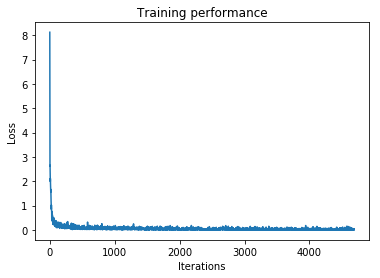

In [10]:
fig, ax = plt.subplots()
ax.plot(loss_history)
ax.set_title('Training performance')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

## Classify Test Dataset

In [11]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True, num_workers=7)
images, labels = next(iter(test_dl))
outputs = net(images.float().cuda())
loss = criterion(outputs.cpu(), labels)
print(f'Test loss of {loss.data.item():.2f}')

Test loss of 0.05


In [12]:
predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
images, labels = images.cpu().numpy(), labels.cpu().numpy()

In [13]:
accuracy = 100.0 * (labels == predicted_labels).sum().item() / len(labels)
print(f'Accuracy on test set is {accuracy}%')

Accuracy on test set is 98.62%


## Plot the first 25 images in the dataset.


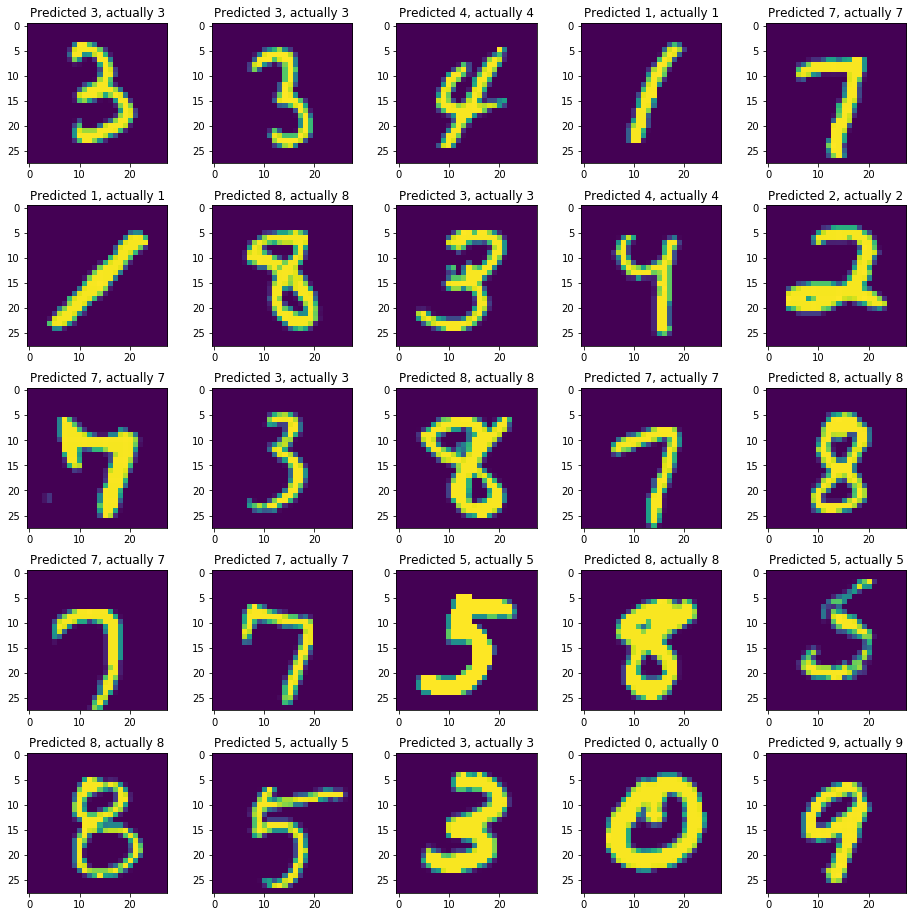

In [14]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16,))

idx = 0

for axarr in axes:
    for ax in axarr:    
        img = images[idx][0]
        pred = predicted_labels[idx]
        true = labels[idx]
        if int(pred) != int(true):
            img = 255 - img

        ax.imshow(img)
        ax.set_title(f'Predicted {pred}, actually {true}')
        idx += 1
        
fig.subplots_adjust(hspace=0.3)

## Plot at most 25 misclassified images.


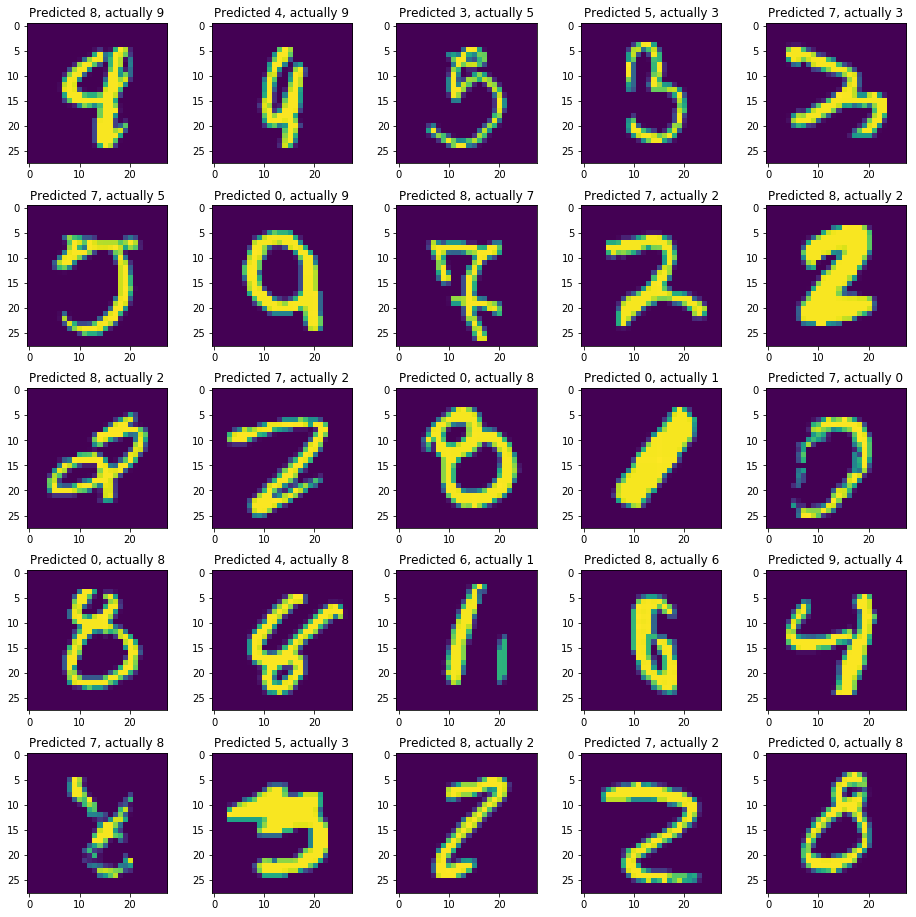

In [97]:
rows, cols = 5, 5
mask = labels != predicted_labels
wrong_images = images[mask][:rows * cols]
wrong_labels = labels[mask][:rows * cols]
wrong_pred = predicted_labels[mask][:rows * cols]

idx = 0
fig, axes = plt.subplots(rows, cols, figsize=(16, 16,))
for axarr in axes:
    for ax in axarr:    
        img, label, predicted = wrong_images[idx], wrong_labels[idx], wrong_pred[idx]
        idx += 1
        ax.imshow(img[0])
        ax.set_title(f'Predicted {predicted}, actually {label}')
        
fig.subplots_adjust(hspace=0.3)